In [115]:
import os
import json
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from sklearn.model_selection import train_test_split

In [116]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

In [117]:
# Import OS libraries
import os
import itertools

# Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# from googleapiclient.discovery import build
# from google.oauth2.credentials import Credentials
# from googleapiclient.http import MediaFileUpload

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

GPU is not available


In [118]:
# Diretório onde estão armazenadas as imagens sem ser separadas por pastas
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'

In [119]:
def load_image(image_path, target_size=(224, 224)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [120]:
# Carregar IDs do grupo de treinamento de um arquivo de texto
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [121]:
# Carregar IDs do grupo de validação de um arquivo de texto
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\vague_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [122]:
# Verificar se os IDs foram carregados corretamente
print(f"IDs de treinamento carregados: {train_ids[:5]} ... ({len(train_ids)} no total)")
print(f"IDs de validação carregados: {val_ids[:5]} ... ({len(val_ids)} no total)")

IDs de treinamento carregados: ['11829', '11828', '11825', '11824', '11827'] ... (644 no total)
IDs de validação carregados: ['12480', '12395', '12486', '12485', '12236'] ... (215 no total)


In [123]:
%%capture
# Listas para armazenar caminhos de imagem e rótulos correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        json_path = os.path.join(image_dir, filename)
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue

        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        classes = json_data.get('classes', [])
        if not classes:
            print(f"Chave 'classes' ausente ou vazia no JSON: {json_path}")
            continue
        
        data_tuple = (image_path, classes[0])
        if sample_id in train_ids:
            train_data.append(data_tuple)
        elif sample_id in val_ids:
            val_data.append(data_tuple)

In [133]:
# Verificar o número de imagens carregadas
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 642
Número de imagens de validação carregadas: 214


In [134]:
train_images = [data[0] for data in train_data]
train_labels = [data[1] for data in train_data]

In [135]:
# Separar as imagens e os rótulos (labels) para validação
val_images = [data[0] for data in val_data]
val_labels = [data[1] for data in val_data]

In [136]:
# Verificar se as listas estão vazias
if len(train_images) == 0:
    print("Nenhuma imagem de treinamento foi carregada.")
if len(val_images) == 0:
    print("Nenhuma imagem de validação foi carregada.")

In [137]:
# Filtrar caminhos de imagem válidos
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [138]:
# Converter as imagens em tensores e normalizar, se necessário
train_images = [load_image(image_path, target_size=(224, 224)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(224, 224)) for image_path in val_images]

In [130]:
# Verificar se alguma imagem falhou ao carregar
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [139]:
# Verificar o shape das imagens e dos rótulos antes da codificação
print("Shape de train_images antes da codificação:", np.array(train_images).shape)
print("Shape de train_labels antes da codificação:", np.array(train_labels).shape)
print("Shape de val_images antes da codificação:", np.array(val_images).shape)
print("Shape de val_labels antes da codificação:", np.array(val_labels).shape)

Shape de train_images antes da codificação: (642, 224, 224, 3)
Shape de train_labels antes da codificação: (642,)
Shape de val_images antes da codificação: (214, 224, 224, 3)
Shape de val_labels antes da codificação: (214,)


In [153]:
def check_image_shapes(image_list):
    for i, img in enumerate(image_list):
        if not isinstance(img, np.ndarray):
            print(f"Item at index {i} is not a numpy array.")
            return False
        if img.shape != (224, 224, 3):
            print(f"Image at index {i} has shape {img.shape} instead of (224, 224, 3).")
            return False
    return True

# Verificar shapes das imagens de treinamento
train_images_valid = check_image_shapes(train_images)
print(f"Todas as imagens de treinamento têm a forma correta: {train_images_valid}")

# Verificar shapes das imagens de validação
val_images_valid = check_image_shapes(val_images)
print(f"Todas as imagens de validação têm a forma correta: {val_images_valid}")

Todas as imagens de treinamento têm a forma correta: True
Todas as imagens de validação têm a forma correta: True


In [154]:
# Converter os rótulos em formato adequado (numérico), se necessário
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [155]:
# Verificar o número de classes
num_classes = len(label_encoder.classes_)
print(f"Número de classes: {num_classes}")


Número de classes: 3


In [156]:
# One-hot encoding dos rótulos após a divisão
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

# Verificar os shapes dos rótulos one-hot encoded
print("Shape de train_labels_one_hot após o one-hot encoding:", train_labels_one_hot.shape)
print("Shape de val_labels_one_hot após o one-hot encoding:", val_labels_one_hot.shape)

Shape de train_labels_one_hot após o one-hot encoding: (642, 3)
Shape de val_labels_one_hot após o one-hot encoding: (214, 3)


In [157]:
#  Criar o modelo da CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [158]:
#  Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [159]:
import numpy as np

# Verificar as dimensões dos dados
print("Shape de train_images:", np.array(train_images).shape)
print("Shape de train_labels_one_hot:", train_labels_one_hot.shape)
print("Shape de val_images:", np.array(val_images).shape)
print("Shape de val_labels_one_hot:", val_labels_one_hot.shape)


Shape de train_images: (642, 224, 224, 3)
Shape de train_labels_one_hot: (642, 3)
Shape de val_images: (214, 224, 224, 3)
Shape de val_labels_one_hot: (214, 3)


In [160]:
# Treinar o modelo novamente
history = model.fit(
    np.array(train_images), 
    train_labels_one_hot, 
    epochs=10, 
    batch_size=32, 
    validation_data=(np.array(val_images), val_labels_one_hot)
)

Epoch 1/10
21/21 [==============================] - 39s 2s/step - loss: 1.0170 - accuracy: 0.5312 - val_loss: 0.8421 - val_accuracy: 0.5701
Epoch 2/10
21/21 [==============================] - 34s 2s/step - loss: 0.7441 - accuracy: 0.7243 - val_loss: 0.6918 - val_accuracy: 0.7477
Epoch 3/10
21/21 [==============================] - 34s 2s/step - loss: 0.6853 - accuracy: 0.7648 - val_loss: 0.6620 - val_accuracy: 0.7477
Epoch 4/10
21/21 [==============================] - 34s 2s/step - loss: 0.6889 - accuracy: 0.7492 - val_loss: 0.6925 - val_accuracy: 0.7523
Epoch 5/10
21/21 [==============================] - 38s 2s/step - loss: 0.6485 - accuracy: 0.7648 - val_loss: 0.5970 - val_accuracy: 0.7523
Epoch 6/10
21/21 [==============================] - 36s 2s/step - loss: 0.5906 - accuracy: 0.7913 - val_loss: 0.4907 - val_accuracy: 0.7757
Epoch 7/10
21/21 [==============================] - 35s 2s/step - loss: 0.5336 - accuracy: 0.8240 - val_loss: 0.4626 - val_accuracy: 0.8645
Epoch 8/10
21/21 [==

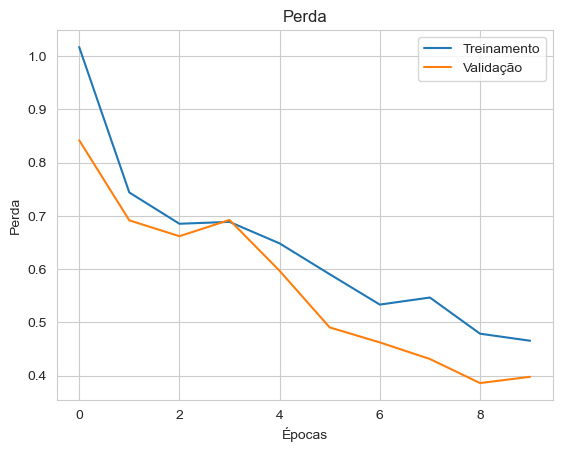

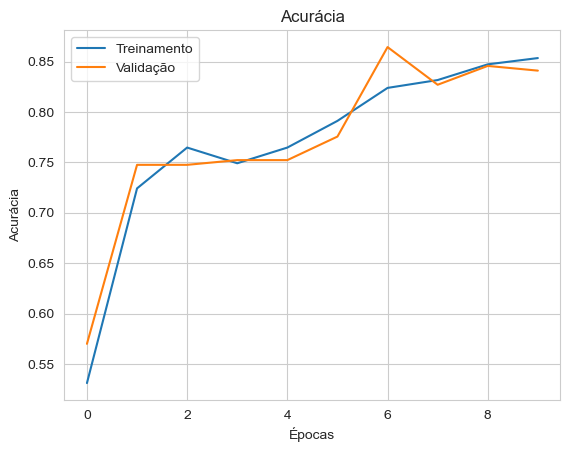

In [163]:
import matplotlib.pyplot as plt

# Plotar perda
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

# Plotar acurácia
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


In [165]:
# Avaliar no conjunto de validação
val_loss, val_accuracy = model.evaluate(np.array(val_images), val_labels_one_hot)
print(f"Loss no conjunto de validação: {val_loss}")
print(f"Accuracy no conjunto de validação: {val_accuracy}")

7/7 [==============================] - 2s 287ms/step - loss: 0.3980 - accuracy: 0.8411
Loss no conjunto de validação: 0.39803335070610046
Accuracy no conjunto de validação: 0.84112149477005


In [167]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))
# Converter previsões one-hot encoded para rótulos
val_predictions_labels = np.argmax(val_predictions, axis=1)
val_labels_labels = np.argmax(val_labels_one_hot, axis=1)

# Matriz de confusão
conf_matrix = confusion_matrix(val_labels_labels, val_predictions_labels)
print("Matriz de Confusão:")
print(conf_matrix)

# Relatório de classificação
class_report = classification_report(val_labels_labels, val_predictions_labels, target_names=['Classe 0', 'Classe 1', 'Classe 2'])
print("Relatório de Classificação:")
print(class_report)


7/7 [==============================] - 2s 283ms/step
Matriz de Confusão:
[[99  2  0]
 [12 81  0]
 [10 10  0]]
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.82      0.98      0.89       101
    Classe 1       0.87      0.87      0.87        93
    Classe 2       0.00      0.00      0.00        20

    accuracy                           0.84       214
   macro avg       0.56      0.62      0.59       214
weighted avg       0.76      0.84      0.80       214



7/7 [==============================] - 2s 310ms/step


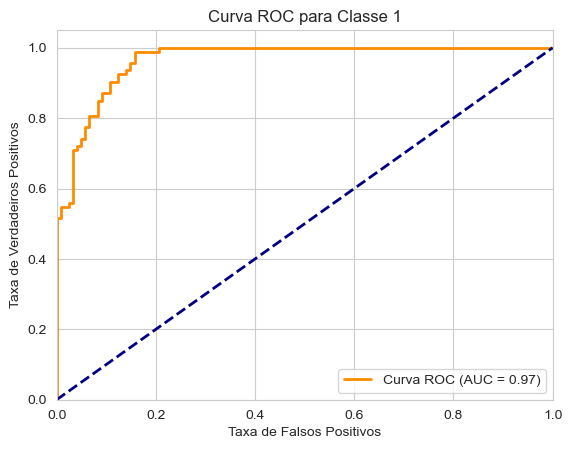

In [169]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))

# Calcular curvas ROC e AUC para a classe 1
fpr, tpr, _ = roc_curve(val_labels_labels, val_predictions[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plotar curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para Classe 1')
plt.legend(loc="lower right")
plt.show()


7/7 [==============================] - 2s 290ms/step


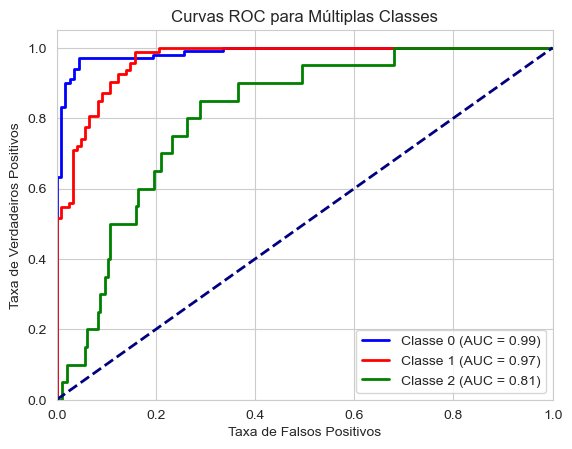

In [170]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarizar os rótulos para múltiplas classes
val_labels_binarized = label_binarize(val_labels_labels, classes=[0, 1, 2])

# Obter previsões do modelo
val_predictions = model.predict(np.array(val_images))

# Inicializar o gráfico
plt.figure()

# Definir cores para cada classe
colors = ['blue', 'red', 'green']
class_names = ['Classe 0', 'Classe 1', 'Classe 2']

# Calcular curvas ROC e AUC para cada classe
for i in range(3):
    fpr, tpr, _ = roc_curve(val_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plotar linha diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC para Múltiplas Classes')
plt.legend(loc="lower right")
plt.show()
